In [1]:
import os
import sys
import matplotlib.pyplot as plt
from pyproj import CRS
from pyresample import geometry
import numpy as np


sys.path.insert(0, '/home/cameron/Projects/hypso-package')

# Import Satellite Object
from hypso import Hypso1

In [2]:
dir_path = '/home/cameron/Dokumenter/Data/frohavet'
nc_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-l1a.nc')
points_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-bin3.points')

#dir_path = '/home/cameron/Dokumenter/Data/erie'
#nc_file = os.path.join(dir_path, 'erie_2022-07-20_1539Z-l1a.nc')
#points_file = os.path.join(dir_path, 'erie_2022-07-20_1539Z-bin3.points')

In [3]:
satobj = Hypso1(hypso_path=nc_file, points_path=points_file, verbose=True)

satobj.generate_l1b_cube()
satobj.generate_land_mask(land_mask='global')


[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running georeferencing...
No image mode provided. Detected image mode: bin3
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632
[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running smile correction...
[INFO] Running destriping correction...
[INFO] Running global land mask generation...
[INFO] Georeferencing has already been run. Skipping.


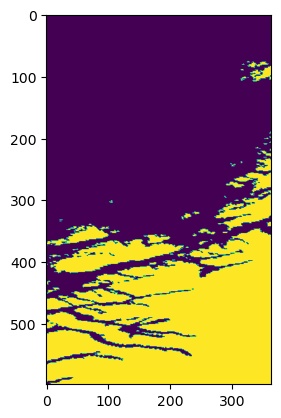

In [5]:
plt.imshow(satobj.get_active_mask()[:,::3])

In [6]:
satobj.generate_chlorophyll_estimates(product='band_ratio')

if False:
    model = "/home/cameron/Dokumenter/Chlorophyll_NN_Models/model_6sv1_aqua_tuned.joblib"
    satobj.generate_chlorophyll_estimates(product="6sv1_aqua", model=model)
    satobj.get_chlorophyll_estimates(product="6sv1_aqua")

[INFO] Running band ratio chlorophyll estimation...
[INFO] Calibration has already been run. Skipping.


In [7]:
l1a_scene = satobj.get_l1a_satpy_scene()
l1b_scene = satobj.get_l1b_satpy_scene()
chl_scene_1 = satobj.get_chlorophyll_satpy_scene(product='band_ratio')
#chl_scene_2 = satobj.get_chlorophyll_satpy_scene(product='6sv1_aqua')

In [6]:
#l1a_scene._datasets.keys()

In [11]:
from satpy.composites import SingleBandCompositor
from trollimage.colormap import ylgnbu, rdbu
from trollimage.image import Image
from satpy.writers import to_image

scene = chl_scene_1

bbox = satobj.get_bbox()

area_id = 'frohavet'
proj_id = 'roi'
description = 'roi'
projection = CRS.from_proj4("+proj=latlon")
width = 1000
height = 1000
area_extent = bbox

area_def = geometry.AreaDefinition(area_id, proj_id, description, projection,  width, height, area_extent)

resampled_scene = scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

alpha = scene._datasets.keys()[0]
alpha = np.where(np.isnan(resampled_scene[alpha]), 0, 1)


compositor = SingleBandCompositor('chla')
composite = compositor([resampled_scene['chl_a']])

img = to_image(composite[:,:]) 


#img = Image(composite[:,:].to_numpy(), mode="L")

rdbu.set_range(1.8,2.2)
rdbu.reverse()
img.colorize(rdbu)

#img.show()
#img.save('./out.png')




#compositor = GenericCompositor("overview")
#composite = compositor([scene['band_89'][:,::3], scene['band_70'][:,::3], scene['band_59'][:,::3], scene['band_89'][:,::3]]) # Red, Green, Blue, Alpha
#gamma = 2
#img = to_image(composite) 
##img.invert([False, False, False])
#img.stretch("linear")
#img.gamma([gamma, gamma, gamma, gamma])
#img.save('./scn.png')

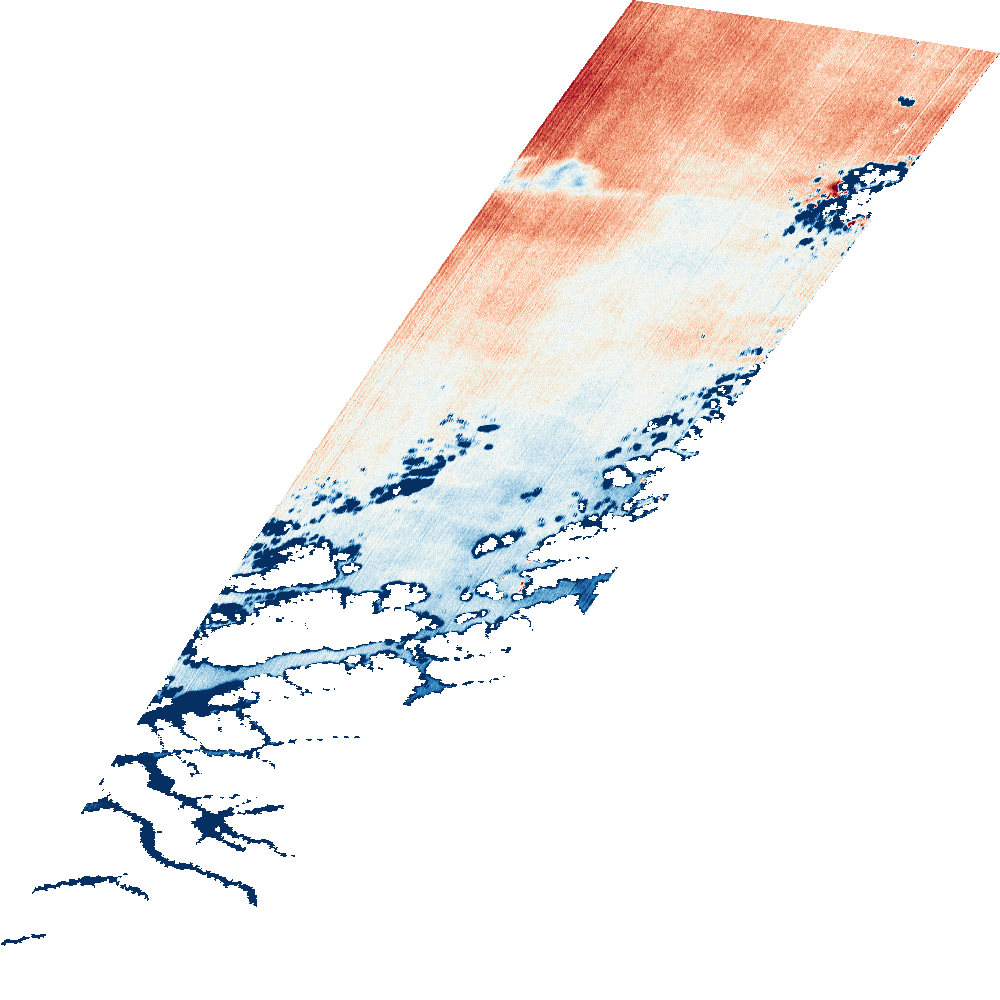

In [12]:
img

In [18]:
chl_scene_1['chl_a']

<xarray.DataArray (y: 598, x: 1092)>
array([[1.98022832, 2.05960769, 2.13993502, ..., 2.07018929, 2.11488065,
        2.13693884],
       [1.99693084, 2.04626501, 2.12055055, ..., 2.074117  , 2.1210269 ,
        2.15617209],
       [1.96243844, 2.06636836, 2.14997843, ..., 2.06486062, 2.10787848,
        2.17818626],
       ...,
       [1.60307765, 1.67246476, 1.69454884, ...,        nan,        nan,
               nan],
       [1.58991106, 1.67528404, 1.70408382, ...,        nan,        nan,
               nan],
       [1.57137012, 1.67516158, 1.68133342, ...,        nan,        nan,
               nan]])
Dimensions without coordinates: y, x
Attributes:
    name:                 chl_a
    _satpy_id:            DataID(name='chl_a')
    file_type:            None
    resolution:           592.8625951680069
    standard_name:        Chlorophyll concentration 549 nm over 663 nm band r...
    coordinates:          ['latitude', 'longitude']
    units:                a.u.
    start_time:           2024-05-06 10:17:00
    end_time:             2024-05-06 10:17:00
    modifiers:            ()
    ancillary_variables:  []
    area:                 Shape: (598, 1092)\nLons: <xarray.DataArray (y: 598...